## Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')

## Load data

In [3]:
labels = pd.read_csv('../ExtractFrames/labels.csv')

In [4]:
FRAMES_PER_SECOND = 3

## Check for unexpected missings

In [5]:
print('Are there null values?: %s' % labels.isnull().values.any())

Are there null values?: False


## How does the data look?

In [6]:
labels.head(10)

,frame,label
0,0,0
1,10,0
2,20,0
3,30,0
4,40,0
5,50,0
6,60,0
7,70,0
8,80,0
9,90,0


## Let's convert this data to something more readable

In [7]:
# Possible labels
# - 0: Ball not in play 
# - 1: Real Madrid has the ball
# - 2: Barcelona has the ball
# - 3: Replay

def get_human_label(label):
    if label == 0:
        return('death ball')
    elif label == 1:
        return('real madrid')
    elif label == 2:
        return('barcelona')
    elif label == 3:
        return('replay')

In [8]:
labels['human_label'] = list(map(get_human_label, labels['label']))
labels['minutes'] = 1 / (60 * FRAMES_PER_SECOND)
labels

,frame,label,human_label,minutes
0,0,0,death ball,0.005556
1,10,0,death ball,0.005556
2,20,0,death ball,0.005556
3,30,0,death ball,0.005556
4,40,0,death ball,0.005556
...,...,...,...,...
8578,85780,3,replay,0.005556
8579,85790,3,replay,0.005556
8580,85800,3,replay,0.005556
8581,85810,3,replay,0.005556


## What's the frequency of every label?

In [9]:
minutes_per_label = labels.groupby('human_label')['minutes']\
                          .sum()\
                          .reset_index()\
                          .sort_values('minutes', ascending = False)

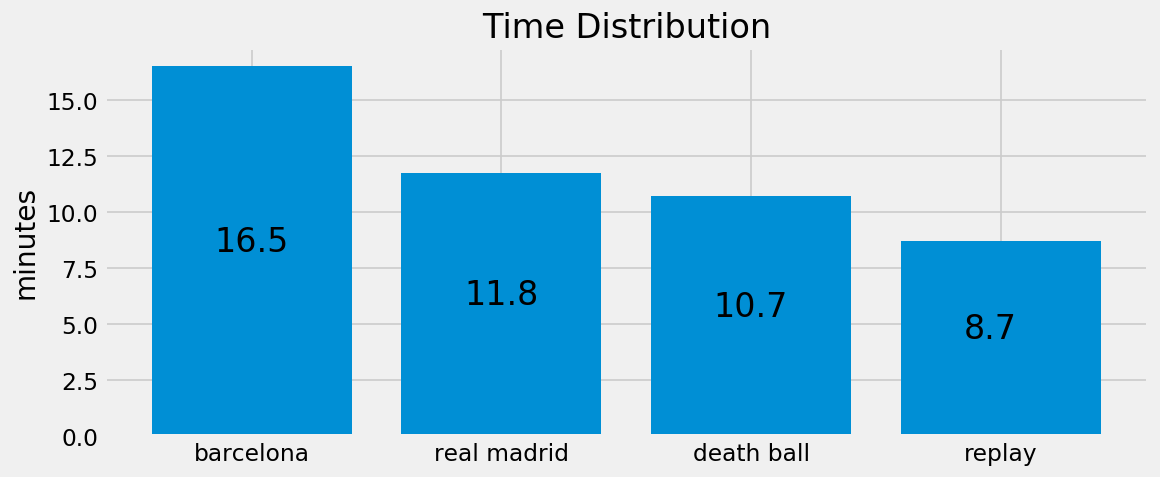

In [10]:
fig, axes = plt.subplots(figsize=(10,4), dpi=120)
plt.bar(minutes_per_label['human_label'], minutes_per_label['minutes'])

for i, v in enumerate(minutes_per_label['minutes']):
    plt.text(i - 0.15, v / 2, str(round(v, 1)), size = 20)

plt.ylabel('minutes')    
plt.title('Time Distribution')
plt.show()

## Does this change throughout time?

In [11]:
pivot_labels = pd.pivot_table(labels, values='minutes', index=['frame'],
                              columns=['human_label'], aggfunc=np.sum, fill_value=0)

pivot_labels['frame'] = pivot_labels.index
pivot_labels = pivot_labels.reset_index(drop=True).rename_axis(None, axis=1)

In [12]:
cum_pivot_labels = pivot_labels.copy()
cum_pivot_labels['barcelona'] = np.cumsum(pivot_labels['barcelona'])
cum_pivot_labels['real madrid'] = np.cumsum(pivot_labels['real madrid'])
cum_pivot_labels['death ball'] = np.cumsum(pivot_labels['death ball'])
cum_pivot_labels['replay'] = np.cumsum(pivot_labels['replay'])

In [13]:
cum_pivot_labels = cum_pivot_labels[['frame', 'barcelona', 'real madrid', 'death ball', 'replay']]

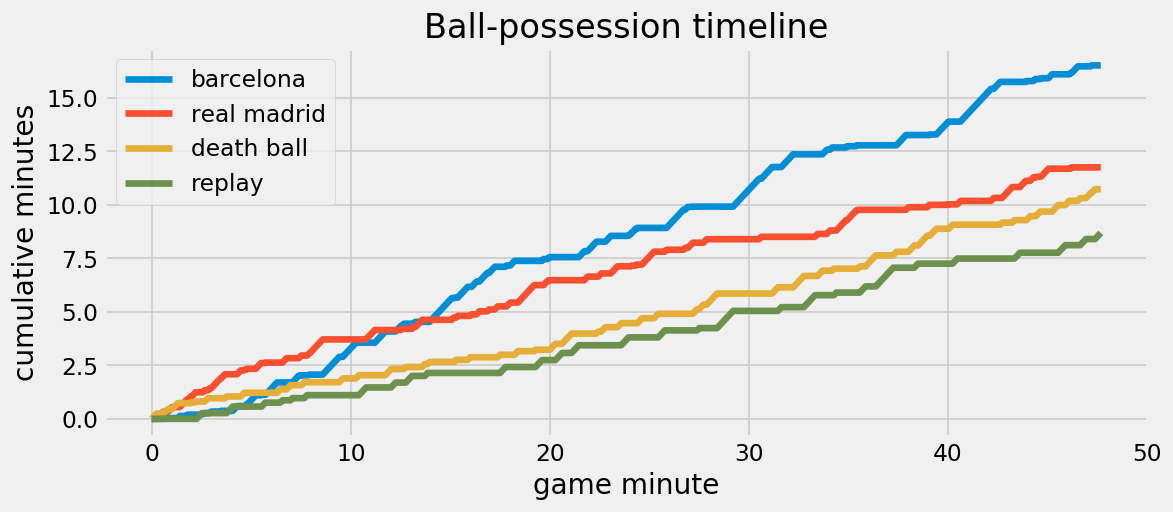

In [14]:
fig, axes = plt.subplots(figsize=(10,4), dpi=120)
minutes = cum_pivot_labels['frame'] / (10 * FRAMES_PER_SECOND * 60)
df_minutes_labels = cum_pivot_labels.drop('frame', axis = 1)
for label in list(df_minutes_labels):
    plt.plot(minutes, df_minutes_labels[label], label = label)

plt.xlabel('game minute')
plt.ylabel('cumulative minutes')
plt.legend()
plt.title('Ball-possession timeline')
plt.show()

## Why there are several jumps in the series? 

In [72]:
time_unit = 1 / FRAMES_PER_SECOND
current_label = labels['human_label'][0]
length = 0
sequences = []

for label in labels['human_label'][:-1]:
    if label == current_label:
        length += time_unit
    else:
        sequences.append((current_label, length))
        current_label = label
        length = time_unit
sequences.append((current_label, length+time_unit)) 
sequences = pd.DataFrame(sequences)
sequences.columns = ['label', 'seconds']

In [73]:
top_sequences = sequences.sort_values('seconds', ascending=False).head(20)

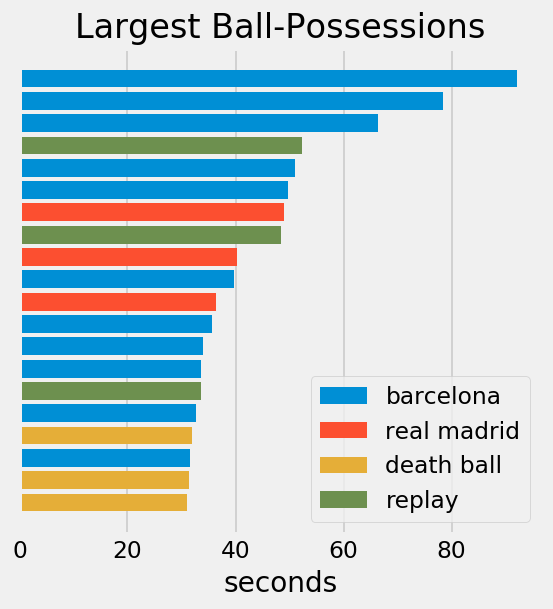

In [82]:
fig, axes = plt.subplots(figsize=(5,5), dpi=120)

y_values = np.arange(top_sequences.shape[0],0,-1)
labels_ = ['barcelona', 'real madrid', 'death ball', 'replay']

for label in labels_:
    mask = top_sequences['label'] == label
    plt.barh(y_values[mask], top_sequences['seconds'][mask], label = label)

plt.legend()
plt.yticks([])
plt.xlabel('seconds')
plt.title('Largest Ball-Possessions')
plt.show()

In [117]:
labels0 = pd.Series(labels['human_label'])
labels1 = pd.Series(list(labels0[1:]) + [list(labels0)[-1]])

## Then, how important is the previous frame to predict the next one?

In [125]:
markov_table = pd.crosstab(labels0, labels1, normalize = 'index', rownames = ['t'], colnames = ['t+1'])
markov_table

t+1,barcelona,death ball,real madrid,replay
t,,,,
barcelona,0.978809,0.008409,0.012445,0.000336
death ball,0.005697,0.972035,0.007768,0.014500
real madrid,0.019385,0.009456,0.971158,0.000000
replay,0.007033,0.005115,0.005754,0.982097
